In [0]:
#Start of import section
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
import csv
import pandas
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Conv2D, Activation, Cropping2D, MaxPooling2D, Dropout, Reshape, Convolution2D
#from keras.layers import softmax
from os import listdir
from os.path import isfile, join
import glob
import PIL
from PIL import Image
import math
#end of import section
#include all the imports within this section.

In [40]:
!rm -rf colab
!git clone https://github.com/anantyash9/colab.git

Cloning into 'colab'...
remote: Counting objects: 3425, done.
remote: Compressing objects: 100% (3409/3409), done.
remote: Total 3425 (delta 15), reused 3419 (delta 14), pack-reused 0
Receiving objects: 100% (3425/3425), 80.77 MiB | 28.40 MiB/s, done.
Resolving deltas: 100% (15/15), done.


In [0]:
#Implementation The Nvidia end to end driving neural net architecture. 
#Added a dropout layer after the 1st convolution_layer to  mitigate overfitting
#Default drop probablity for any dropout layer added is kept at 0.2.
def NvidiaNet(drop_prob = 0.2):
    #create a sequential Model
    model = Sequential()
    
    #Add a Cropping layer to trim the unneeded portions of the IMAGE from the feed
    #model.add(Cropping2D)
    #model.add(Reshape((50,50,3), input_shape=(None,None,3))
    model.add(Cropping2D(cropping = ((0, 0), (0,0)), input_shape = (100 ,100 ,3)))
    
    #Normalization Layer
    #model.add(Lambda(lambda X_input: (X_input/255.0 - 0.5)))

    #Conv2D Layer 1 with 5 x 5 kernal size
    #model.add(Convolution2D(nb_filter = 3, nb_row = 5, nb_col = 5))
    model.add(Convolution2D(nb_filter = 12, nb_row = 3, nb_col = 3, subsample=(1,1)))
    model.add(Activation('relu'))

    #Dropout layer
    model.add(Dropout(drop_prob))
    
    #Conv2D Layer 2 with 5 x 5 kernal size
    #model.add(Convolution2D(nb_filter = 24, nb_row = 5, nb_col = 5))
    model.add(Conv2D(nb_filter = 24, nb_row = 3, nb_col = 3,subsample=(2,2)))
    model.add(Activation('relu'))

    #Conv2D Layer 3 with 5 x 5 kernal size
    #model.add(Convolution2D(nb_filter = 36, nb_row = 5, nb_col =  5))
    model.add(Conv2D(nb_filter = 36, nb_row = 3, nb_col =  3,subsample=(1,1)))
    model.add(Activation('relu'))
    
    #Dropout layer
    model.add(Dropout(drop_prob))

    #Conv2D Layer 4 with 3 x 3 kernal size
    #model.add(Convolution2D(nb_filter = 48, nb_row = 3, nb_col = 3))
    model.add(Conv2D(nb_filter = 48, nb_row = 3, nb_col = 3))
    model.add(Activation('relu'))

    #Conv2D Layer 5 with 3 x 3 kernal size
    #model.add(Convolution2D(nb_filter = 48, nb_row = 3, nb_col = 3))
    model.add(Conv2D(nb_filter = 64, nb_row = 3, nb_col = 3))
    model.add(Activation('relu'))

    #flatten layer
    #flatten the output from convolution Layer
    model.add(Flatten())

    #Fully connected layer 1
    model.add(Dense(output_dim = 50))

    #Fully connected Layer 2
    model.add(Dense(output_dim = 25))

    #Fully connected Layer 3
    model.add(Dense(output_dim = 10))

    #output Layers
    model.add(Dense(output_dim = 2, activation='softmax') )

    return model


In [57]:
model = NvidiaNet(drop_prob = 0.2)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_19 (Cropping2D)   (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 98, 98, 12)        336       
_________________________________________________________________
activation_91 (Activation)   (None, 98, 98, 12)        0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 98, 98, 12)        0         
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 48, 48, 24)        2616      
_________________________________________________________________
activation_92 (Activation)   (None, 48, 48, 24)        0         
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 46, 46, 36)        7812      
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(kernel_size=(3, 3), filters=12, strides=(1, 1))`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(kernel_size=(3, 3), filters=24, strides=(2, 2))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(kernel_size=(3, 3), filters=36, strides=(1, 1))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(kernel_size=(3, 3), filters=48)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(kernel_size=(3, 3), filters=64)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: Update y

In [0]:

def list_files(path):
    #files = [f for f in listdir(path) if isfile(join(path, f))]
    #return files
    return glob.glob(path)

#Perform horizontal flip and return the image and angles
def horizontal_flip(img):
    hor_flip = cv2.flip(img, 1)
    return hor_flip

def make_square(im, min_size=100, fill_color=(0, 0, 0, 0)):
    x, y = im.size
    size = max(min_size, x, y)
    new_im = Image.new('RGB', (size, size), fill_color)
    #print((int((size - x) / 2), int(size - y) / 2))
    new_im.paste(im, (int((size - x) / 2), int((size - y) / 2)))
    return new_im

#Takes a image path as input and reads the corresponding image from the disk present in the ./data path.
#converts the image to RGB color model and returns it.
def read_image(path):
    img = PIL.Image.open(path).convert('RGB')
    img = make_square(img)
    img = img.resize((100, 100), Image.ANTIALIAS)
    img = np.asarray(img)
    img = (img/255)-0.5
    #open_cv_image = numpy.array(pil_image) 
    # Convert RGB to BGR 
    #open_cv_image = open_cv_image[:, :, ::-1].copy()
    #img = cv2.imread(path)
    
    #img = cv2.resize(img, (100, 100))
    #rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #print(rgb.shape)
    return img


#outputs the images and the measurements for the corresponding images persistantly as a subroutine
def generator(samples, batch_size = 32): 
    num_samples = len(samples)
    print(num_samples)
    while 1: #to run the generator indefinitely, pumping the X, Y sets for the neural network
        #shuffle the samples on each EPOCH
        sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset: offset + batch_size]
            
            images = []
            labels = []

            for batch_sample in batch_samples:
                
                '''
                read the image from center camera directly from the disk. 
                No color model conversion performed for the center image
                center image flipped and taken as input irrespective of the center angle.
                '''
                
                name =  batch_sample[0]
                image = read_image(name)
                images.append(image)
                labels.append(batch_sample[1])
                #flip_output = horizontal_flip(center_image, center_angle)
                #images.append(flip_output[0])
                #angles.append(flip_output[1])
                
                
            #Convert the cv2 images and the measurements into numpy array
            X_train = np.array(images)
            Y_train = np.array(labels)
            yield sklearn.utils.shuffle(X_train, Y_train)


In [7]:
#testing
def load_trained_model(weights_path):
    model = NvidiaNet()
    model.load_weights(weights_path)
    return model


#fishing = load_trained_model("./model.h5")

#score = fishing.evaluate(x_test, y_test, batch_size=32)
img = read_image(samples[10][0])
#prediction = fishing.predict(np.expand_dims(img, axis=0))
plt.imshow(img)
plt.show()
#print(prediction)

NameError: ignored

In [0]:
def process_files(list_files, label):
    output = []
    for i in list_files:
        temp = []
        temp.append(i)
        l = [0, 0]
        l[label] = 1.
        temp.append(l)
        output.append(temp)
    return output

#print(process_files(['a','b','c','d'], 0))

In [0]:
#legit 1, Nope 0
samples_legit = list_files("./colab/clothes_data/legit/*.jpg")
samples_nope = list_files("./colab/clothes_data/nope/*.jpg")

In [0]:
def make_flips(samples):
  for files in samples:
    img = cv2.imread(files)
    new_name = files[:-4]+'_flip.jpg'
    vertical_img = cv2.flip( img, 1 )
    cv2.imwrite(new_name,vertical_img)
make_flips(samples_nope)    

In [61]:
samples_nope = list_files("./colab/clothes_data/nope/*.jpg")
print(len(samples_legit))
print(len(samples_nope))
samples = process_files(samples_legit, 1) + process_files(samples_nope, 0)

1211
768


In [62]:
#testing

train_samples, validation_samples = train_test_split(samples, test_size=0.2)
print(train_samples[1])

['./colab/clothes_data/nope/image_2409_flip.jpg', [1.0, 0]]


In [68]:
#The execution portion of the code.
#save a model

model = NvidiaNet(drop_prob = 0.2)
model.summary()
model.compile(loss='mse', optimizer='adam',metrics=['accuracy'])


sklearn.utils.shuffle(samples)
train_samples, validation_samples = train_test_split(samples, test_size=0.2)
print(train_samples[1])

#Hyperparameters
train_generator = generator(train_samples, 16)
validation_generator = generator(validation_samples)
epoch = 1
#end of hyperparameters

history = model.fit_generator(train_generator, samples_per_epoch = len(train_samples), validation_data = validation_generator,\
                   nb_val_samples = len(validation_samples), nb_epoch = epoch)
model.save("model.h5")
print("Model Generated")



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(kernel_size=(3, 3), filters=12, strides=(1, 1))`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(kernel_size=(3, 3), filters=24, strides=(2, 2))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(kernel_size=(3, 3), filters=36, strides=(1, 1))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(kernel_size=(3, 3), filters=48)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(kernel_size=(3, 3), filters=64)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: Update y

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_25 (Cropping2D)   (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_121 (Conv2D)          (None, 98, 98, 12)        336       
_________________________________________________________________
activation_121 (Activation)  (None, 98, 98, 12)        0         
_________________________________________________________________
dropout_49 (Dropout)         (None, 98, 98, 12)        0         
_________________________________________________________________
conv2d_122 (Conv2D)          (None, 48, 48, 24)        2616      
_________________________________________________________________
activation_122 (Activation)  (None, 48, 48, 24)        0         
_________________________________________________________________
conv2d_123 (Conv2D)          (None, 46, 46, 36)        7812      
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_data=<generator..., steps_per_epoch=1583, epochs=1, validation_steps=396)`


Epoch 1/1
1583
1238/1583 [======================>.......] - ETA: 19s - loss: 0.0573 - acc: 0.9287

1583/1583 [==============================] - 123s 78ms/step - loss: 0.0505 - acc: 0.9380 - val_loss: 0.0406 - val_acc: 0.9524
Model Generated


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


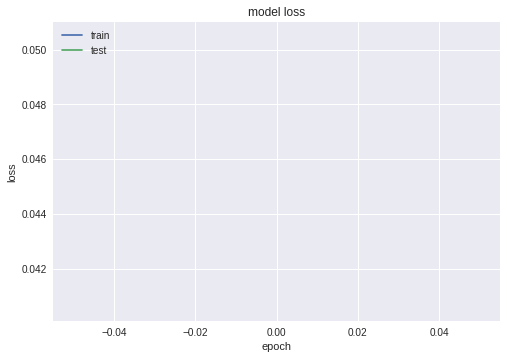

In [69]:
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [28]:
print(train_samples[0])
img_list = []
name = './data/IMG/' + train_samples[0][0].split('/')[-1]
center_image = cv2.imread(name)
left_image = read_image(train_samples[0][1])
right_image = read_image(train_samples[0][2])
img_list.append(center_image)
img_list.append(left_image)
img_list.append(right_image)

flip_output = horizontal_flip(center_image, 0)
img_list.append(flip_output[0])
flip_output = horizontal_flip(left_image, 0)
img_list.append(flip_output[0])
flip_output = horizontal_flip(right_image, 0)
img_list.append(flip_output[0])

fig = plt.figure(figsize=(75, 150))
# plt.imshow(center_image)
# plt.imshow(flip_image)
columns = 3
rows = 2
w=100
h=100
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_list[i-1])
plt.show()




['./colab/clothes_data/nope/image_1421.jpg', [1.0, 0]]


AttributeError: ignored

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(kernel_size=(3, 3), filters=12, strides=(1, 1))`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(kernel_size=(3, 3), filters=24, strides=(2, 2))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(kernel_size=(3, 3), filters=36, strides=(1, 1))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(kernel_size=(3, 3), filters=48)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(kernel_size=(3, 3), filters=64)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: Update y

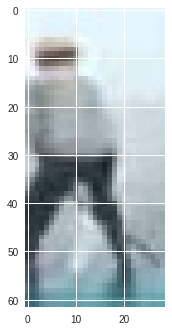

legit : 100.0   nope :  6.898957311371477e-27


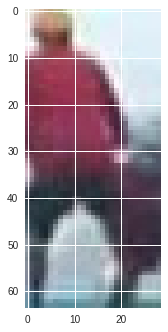

legit : 100.0   nope :  1.4711313764403933e-10


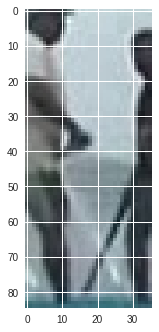

legit : 100.0   nope :  1.5201194202186944e-13


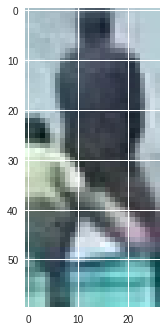

legit : 100.0   nope :  4.1692864438669375e-11


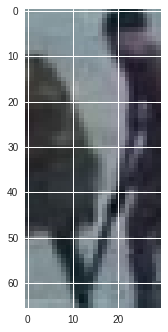

legit : 99.99995231628418   nope :  5.2384649507075665e-05


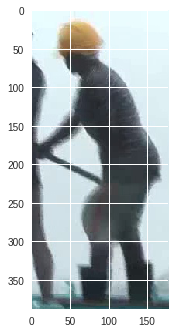

legit : 100.0   nope :  1.7579601308188343e-12


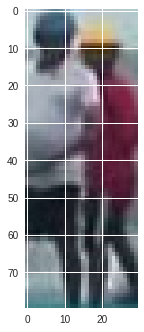

legit : 100.0   nope :  1.1251393410007538e-16


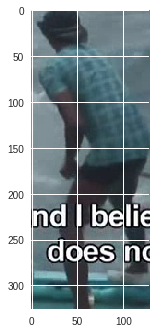

legit : 99.87653493881226   nope :  0.12346908915787935


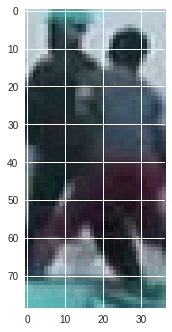

legit : 99.99809265136719   nope :  0.0019121767763863318


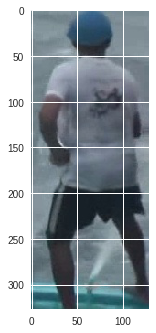

legit : 96.96487784385681   nope :  3.0351202934980392


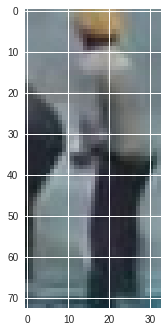

legit : 99.9998688697815   nope :  0.00013684401665159385


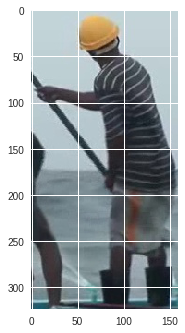

legit : 100.0   nope :  1.051408201175249e-25


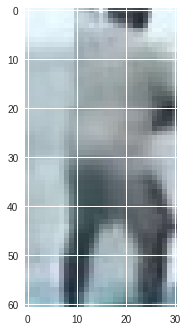

legit : 100.0   nope :  2.5402968074409696e-14


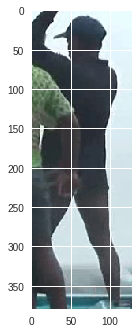

legit : 100.0   nope :  1.1934172400307475e-09


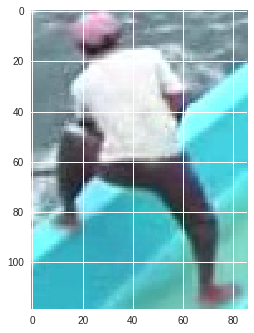

legit : 100.0   nope :  0.0


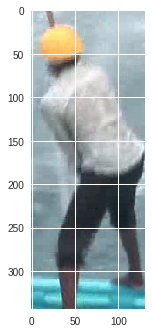

legit : 100.0   nope :  0.0


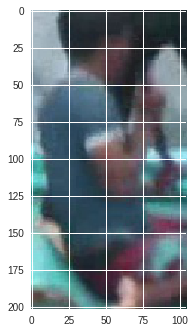

legit : 98.50879311561584   nope :  1.491201389580965


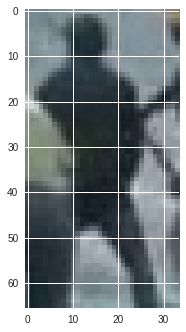

legit : 99.95856881141663   nope :  0.04142643301747739


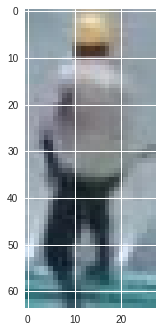

legit : 100.0   nope :  5.519675970629134e-12


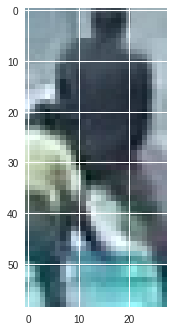

legit : 100.0   nope :  1.4369595291441328e-06


In [105]:
import matplotlib.image as mpimg
def load_trained_model(weights_path):
    model = NvidiaNet()
    model.load_weights(weights_path)
    return model


fishing = load_trained_model("./model.h5")

#score = fishing.evaluate(x_test, y_test, batch_size=32)
for sampl in samples_legit[:20]:
  img=mpimg.imread(sampl)
  plt.imshow(img)
  img = read_image(sampl)
  prediction = fishing.predict(np.expand_dims(img, axis=0))
  #plt.imshow(img)
  plt.show()
  print('legit :' ,prediction[0][1]*100 , '  nope : ' , prediction[0][0]*100)
plt.show()
   

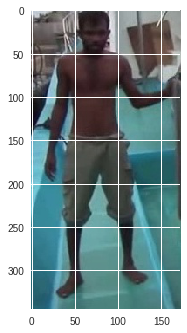

legit : 0.0003059129085158929   nope :  99.99969005584717


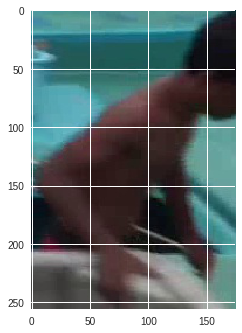

legit : 1.1080896200610368e-07   nope :  100.0


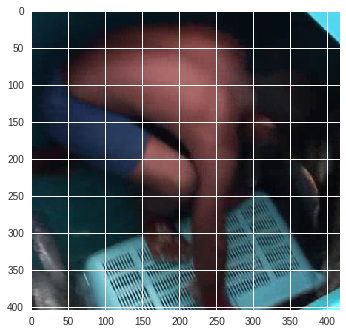

legit : 0.9919816628098488   nope :  99.0080177783966


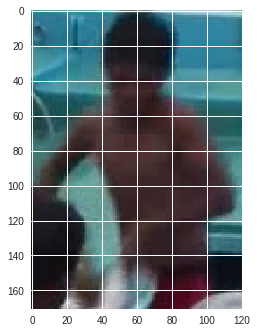

legit : 0.0003317293931104359   nope :  99.99966621398926


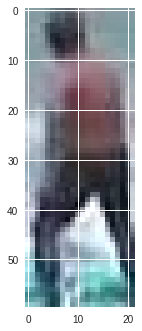

legit : 0.03144661313854158   nope :  99.9685525894165


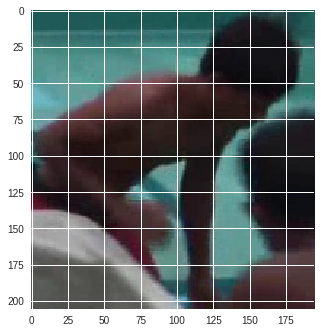

legit : 1.0481849699317536e-05   nope :  99.99998807907104


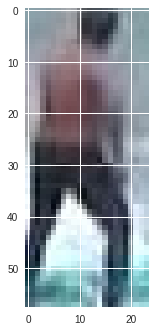

legit : 0.0005286934992909664   nope :  99.99947547912598


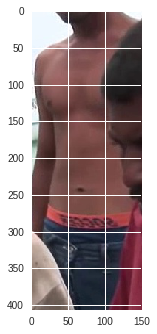

legit : 3.0701866648996656e-05   nope :  99.99996423721313


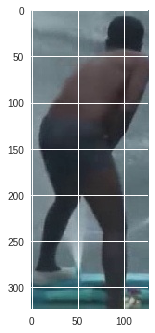

legit : 0.006269232835620642   nope :  99.99372959136963


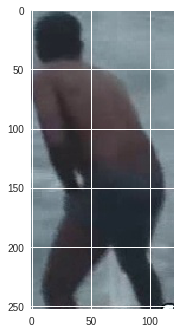

legit : 66.14015698432922   nope :  33.85984003543854


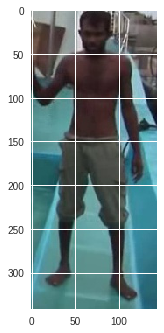

legit : 0.0005651424544339534   nope :  99.99943971633911


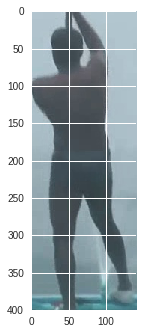

legit : 5.698823635214012e-08   nope :  100.0


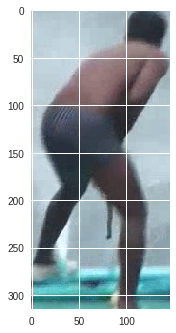

legit : 4.874659703668627e-11   nope :  100.0


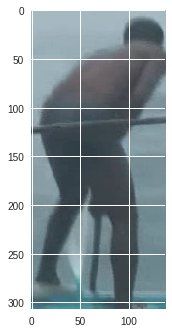

legit : 4.92330487489312e-07   nope :  100.0


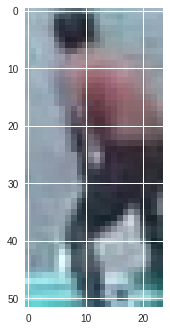

legit : 0.16964944079518318   nope :  99.83035326004028


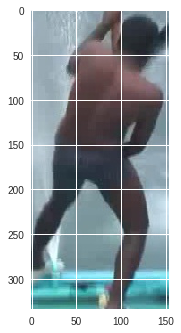

legit : 6.942121322239814e-08   nope :  100.0


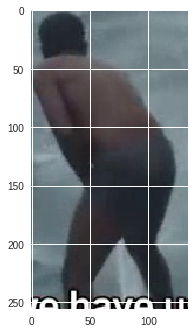

legit : 0.003988809839938767   nope :  99.99600648880005


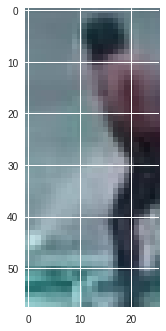

legit : 0.010768030188046396   nope :  99.98923540115356


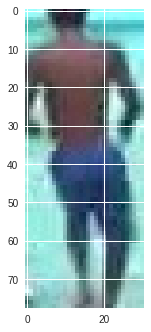

legit : 0.11550533818081021   nope :  99.88449811935425


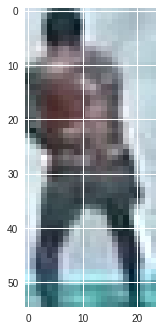

legit : 0.006483300239779055   nope :  99.99351501464844


In [106]:
for sampl in samples_nope[:20]:
  img=mpimg.imread(sampl)
  plt.imshow(img)
  img = read_image(sampl)
  prediction = fishing.predict(np.expand_dims(img, axis=0))
  #plt.imshow(img)
  plt.show()
  print('legit :' ,prediction[0][1]*100 , '  nope : ' , prediction[0][0]*100)
plt.show()


In [103]:
cd ..

/content


In [104]:
ls

colab/  datalab/  model.h5
